# Market Regime Modeling - v1.0

https://lucid.app/lucidchart/1d1da6ad-2f5b-404e-a2e0-5fc09d555908/edit?view_items=sDP_6P2O9gUE&invitationId=inv_f6dfc2ff-a89c-4265-bff5-bedbb0340d49

In [2]:
# Libraries
import os
import pandas as pd
import numpy as np

#plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

# 1.Data Preparation

## Data loading

In [3]:
dir = os.getcwd()

# Load dataset
raw_data = pd.read_csv(os.path.join(dir,"INPUT/index_data.csv"))
raw_data['Date'] = pd.to_datetime(raw_data['Date'], format='%d/%m/%y') # Convert date to datetime format from 8/2/23 to 2023-08-02
raw_data.set_index('Date', inplace=True) # Set date as index
raw_data.dropna(axis='columns', inplace=True) # Data preprocessing - remove error/outliers

# Load reference data
ref_data = pd.read_csv(os.path.join(dir,'INPUT/index_set.csv'))
df_index_set = ref_data[ref_data['group']==1][['set','index']]

In [4]:
raw_data.index.min()

Timestamp('2005-04-01 00:00:00')

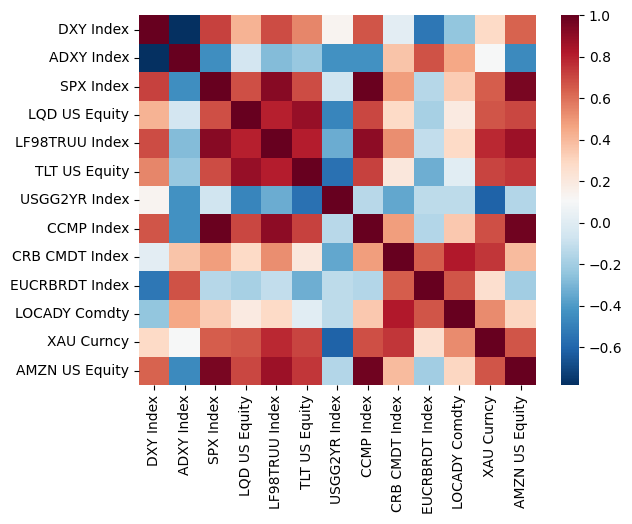

In [4]:
#heatmap of correlation
sns.heatmap(raw_data.corr(),annot=False,cmap='RdBu_r')
plt.show()

In [7]:
raw_data.tail()

,DXY Index,ADXY Index,SPX Index,LQD US Equity,LF98TRUU Index,TLT US Equity,USGG2YR Index,CCMP Index,CRB CMDT Index,EUCRBRDT Index,LOCADY Comdty,XAU Curncy,AMZN US Equity
Date,,,,,,,,,,,,,
2023-02-08,103.409,102.46,4117.86,109.44,2276.17,105.56,4.4208,11910.52,553.96,84.56,9006.0,1875.49,100.05
2023-02-09,103.221,102.48,4081.50,108.52,2271.06,104.56,4.4820,11789.58,554.56,83.53,8953.5,1861.78,98.24
2023-02-10,103.630,102.17,4090.46,107.76,2253.47,103.39,4.5170,11718.12,553.72,85.87,8905.0,1865.57,97.61
2023-02-13,103.345,102.02,4137.29,108.16,2255.03,104.26,4.5175,11891.79,553.72,85.22,8912.0,1853.49,99.54
2023-02-14,103.221,102.07,4137.29,108.16,2255.03,104.26,4.5090,11891.79,553.72,85.12,8912.0,1856.01,99.54


In [6]:
df_index_set

,set,index
0,US_equity,SPX Index
1,Asian_currency,ADXY Index
2,US_bond_gov,TLT US Equity
3,US_bond_hg,LQD US Equity
4,Copper,LOCADY Comdty
5,US_rates,USGG2YR Index
6,US_equity_AMZN,AMZN US Equity
7,Crude oil,EUCRBRDT Index


## Feature engineering

In [3]:
# variables
base_index_name = "XAU Curncy" # Gold
# Base_index = "EUCRBRDT Index" # Crude oil

li_rolling_window = [
    10, # 2W
    21, # 1M
    42, # 2M
    65, # 3M
    ]
li_calculation_type = [
    "MA",
    "STD",
    "DIFF",
    ]

start_date = None
end_date = None      

In [13]:
#ignore warining
import warnings
warnings.filterwarnings('ignore')

from datapreprocessing import DataPreprocessing

data_pre = DataPreprocessing(data = raw_data, 
                             base_index = base_index_name,
                             rolling_windows = li_rolling_window,
                             calculation_types = li_calculation_type,
                             start_date = start_date,
                             end_date = end_date,
                             grouped = True,
                             index_set = df_index_set,
                             rounded = True,
                             round_level = 8)

derived_data = data_pre.construct_market_data()


In [14]:
derived_data.tail(5)

,US_equity_MA10,US_equity_STD10,US_equity_DIFF10,US_equity_MA21,US_equity_STD21,US_equity_DIFF21,US_equity_MA42,US_equity_STD42,US_equity_DIFF42,US_equity_MA65,...,Crude oil_DIFF10,Crude oil_MA21,Crude oil_STD21,Crude oil_DIFF21,Crude oil_MA42,Crude oil_STD42,Crude oil_DIFF42,Crude oil_MA65,Crude oil_STD65,Crude oil_DIFF65
Date,,,,,,,,,,,,,,,,,,,,,
2023-02-08,1,0.250,1,1,0.25,1,1,0.125,0,1,...,1,1,0.000,1,1,0.000,1,0,0.125,0
2023-02-09,1,0.250,1,1,0.25,1,1,0.125,0,1,...,0,1,0.000,1,1,0.000,1,0,0.125,0
2023-02-10,1,0.250,1,1,0.25,1,1,0.125,0,1,...,1,1,0.000,1,1,0.000,1,1,0.125,0
2023-02-13,1,0.125,1,1,0.25,1,1,0.125,1,1,...,1,1,0.000,1,1,0.000,1,1,0.125,0
2023-02-14,1,0.125,1,1,0.25,1,1,0.125,1,1,...,1,1,0.125,1,1,0.125,1,1,0.125,0


In [ ]:
# data download
#derived_data.to_csv(os.path.join(dir,'INPUT/market_data.csv'))

# 2. Data Analyisis

## Load processed data

In [5]:
# load data
dir = os.getcwd()
df_derived = pd.read_csv(os.path.join(dir,'INPUT/market_data.csv'), index_col=0)

In [6]:
market_data_PCA = df_derived.copy()
#select columns that do NOT start with 'US_equity_AMZN', which is the relabled column
market_data = df_derived.loc[:,~df_derived.columns.str.startswith('US_equity_AMZN')]     # why?: to remove AMZN

In [7]:
market_data

,US_equity_MA10,US_equity_STD10,US_equity_DIFF10,US_equity_MA21,US_equity_STD21,US_equity_DIFF21,US_equity_MA42,US_equity_STD42,US_equity_DIFF42,US_equity_MA65,...,Crude oil_DIFF10,Crude oil_MA21,Crude oil_STD21,Crude oil_DIFF21,Crude oil_MA42,Crude oil_STD42,Crude oil_DIFF42,Crude oil_MA65,Crude oil_STD65,Crude oil_DIFF65
Date,,,,,,,,,,,,,,,,,,,,,
2005-06-30,0,0.125,0,0,0.125,0,0,0.125,1,0,...,1,1,0.125,1,1,0.125,1,1,0.125,0
2005-07-01,1,0.125,1,1,0.125,0,0,0.125,1,1,...,1,1,0.125,1,1,0.125,1,1,0.125,1
2005-07-04,1,0.125,1,1,0.125,0,0,0.125,1,1,...,1,1,0.125,1,1,0.125,1,1,0.125,1
2005-07-05,1,0.125,1,1,0.125,1,1,0.125,1,1,...,1,1,0.125,1,1,0.125,1,1,0.125,1
2005-07-06,1,0.125,1,1,0.125,1,1,0.125,1,1,...,1,1,0.125,1,1,0.125,1,1,0.125,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-08,1,0.250,1,1,0.250,1,1,0.125,0,1,...,1,1,0.000,1,1,0.000,1,0,0.125,0
2023-02-09,1,0.250,1,1,0.250,1,1,0.125,0,1,...,0,1,0.000,1,1,0.000,1,0,0.125,0
2023-02-10,1,0.250,1,1,0.250,1,1,0.125,0,1,...,1,1,0.000,1,1,0.000,1,1,0.125,0


In [8]:
market_data.shape

(4599, 84)

## PCA

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

market_data_transformed = StandardScaler().fit_transform(market_data_PCA)
pca = PCA()
principalComponents = pca.fit_transform(market_data_transformed)

principalDf = pd.DataFrame(data = principalComponents, columns=market_data_PCA.columns)
Ranking_PC0 = abs(principalDf.iloc[0,:])
Ranking_PC0.sort_values(ascending=False, inplace=True)

Ranking_PC1 = abs(principalDf.iloc[1,:])
Ranking_PC1.sort_values(ascending=False, inplace=True)

print('PC0 ranking')
print(Ranking_PC0[:10])
print()


print('PC1 ranking')
print(Ranking_PC1[:10])
print()
pca.explained_variance_ratio_.round(2)

PC0 ranking
US_equity_DIFF21        3.439008
US_equity_STD10         2.974205
US_equity_MA42          2.829485
US_equity_STD21         2.338100
US_equity_MA21          2.151221
US_bond_gov_MA10        1.925415
Asian_currency_STD10    1.900906
Asian_currency_STD21    1.894926
Asian_currency_MA21     1.416927
US_bond_hg_STD65        1.386495
Name: 0, dtype: float64

PC1 ranking
US_equity_MA10          3.646182
US_equity_STD21         3.301785
US_equity_MA42          3.215805
Asian_currency_MA21     2.862342
US_equity_MA65          2.230058
US_equity_MA21          1.460180
US_equity_STD65         1.405146
Asian_currency_MA10     1.396538
Asian_currency_MA42     1.375423
Asian_currency_STD10    1.347247
Name: 1, dtype: float64



array([0.19, 0.13, 0.07, 0.05, 0.04, 0.04, 0.04, 0.03, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

# 3. Model

In [10]:
from model import HighDimensionalClustering
umap_kmeans = HighDimensionalClustering(reducer_name = 'UMAP', 
                                        dimension= 2, 
                                        Nneighbor=30, 
                                        clustering_model_name = 'kMeans', 
                                        Ncluster = 9)
umap_kmeans.clustering(market_data)

In [11]:
# add labels to the data
clusterable_embedding = umap_kmeans.low_dimension_embedding
labels = umap_kmeans.labels
df_labeled = market_data.copy()
df_labeled['label'] = labels

In [12]:
# rename the labels by statistics of each cluster

def rename_labels(df_labeled, relabel_col):

    # rename lablels: rank of mean of US_equity_MA65 in each kmeans cluster(label) 
    df_summary = df_labeled.groupby("label")[relabel_col].describe()
    #df_summary['relabel'] = df_summary['mean'].rank(ascending= False).astype(int)
    df_summary['relabel'] = df_summary['mean'].rank().astype(int)

    # add column 'relabel' to df_labeled, keep the index of df_labeled
    df_relabeled = df_labeled.join(df_summary['relabel'], on = 'label')

    return df_relabeled

In [13]:
df_relabeled = rename_labels(df_labeled, "US_equity_MA21")
df_relabeled

,US_equity_MA10,US_equity_STD10,US_equity_DIFF10,US_equity_MA21,US_equity_STD21,US_equity_DIFF21,US_equity_MA42,US_equity_STD42,US_equity_DIFF42,US_equity_MA65,...,Crude oil_STD21,Crude oil_DIFF21,Crude oil_MA42,Crude oil_STD42,Crude oil_DIFF42,Crude oil_MA65,Crude oil_STD65,Crude oil_DIFF65,label,relabel
Date,,,,,,,,,,,,,,,,,,,,,
2005-06-30,0,0.125,0,0,0.125,0,0,0.125,1,0,...,0.125,1,1,0.125,1,1,0.125,0,8,3
2005-07-01,1,0.125,1,1,0.125,0,0,0.125,1,1,...,0.125,1,1,0.125,1,1,0.125,1,5,9
2005-07-04,1,0.125,1,1,0.125,0,0,0.125,1,1,...,0.125,1,1,0.125,1,1,0.125,1,5,9
2005-07-05,1,0.125,1,1,0.125,1,1,0.125,1,1,...,0.125,1,1,0.125,1,1,0.125,1,5,9
2005-07-06,1,0.125,1,1,0.125,1,1,0.125,1,1,...,0.125,1,1,0.125,1,1,0.125,1,5,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-08,1,0.250,1,1,0.250,1,1,0.125,0,1,...,0.000,1,1,0.000,1,0,0.125,0,3,6
2023-02-09,1,0.250,1,1,0.250,1,1,0.125,0,1,...,0.000,1,1,0.000,1,0,0.125,0,3,6
2023-02-10,1,0.250,1,1,0.250,1,1,0.125,0,1,...,0.000,1,1,0.000,1,1,0.125,0,3,6


In [14]:
# Calculate summary statistics for "US_equity_MA65" grouped by "ranking"
df_relabeled.groupby("relabel")["US_equity_MA65"].describe()

,count,mean,std,min,25%,50%,75%,max
relabel,,,,,,,,
1,720.0,0.054167,0.226504,0.0,0.0,0.0,0.0,1.0
2,521.0,0.084453,0.278333,0.0,0.0,0.0,0.0,1.0
3,450.0,0.215556,0.411665,0.0,0.0,0.0,0.0,1.0
4,593.0,0.689713,0.463001,0.0,0.0,1.0,1.0,1.0
5,598.0,0.904682,0.293899,0.0,1.0,1.0,1.0,1.0
6,454.0,0.314978,0.465020,0.0,0.0,0.0,1.0,1.0
7,363.0,0.933884,0.248827,0.0,1.0,1.0,1.0,1.0
8,439.0,0.990888,0.095127,0.0,1.0,1.0,1.0,1.0
9,461.0,0.982646,0.130727,0.0,1.0,1.0,1.0,1.0


In [15]:
clusterable_embedding

array([[ 7.9060545 , -0.33982354],
       [ 1.1931998 ,  1.3248568 ],
       [ 1.3221667 ,  1.3883157 ],
       ...,
       [ 6.111431  ,  1.4826388 ],
       [ 2.1762574 ,  0.7848357 ],
       [ 2.183158  ,  0.7416349 ]], dtype=float32)

# Visualization

In [16]:
from visualizer import ClusterVisualizer
visualizer = ClusterVisualizer(clusterable_embedding, labels = np.array(df_relabeled['relabel']),trace = True)
fig = visualizer.plot_2d()
fig.show()

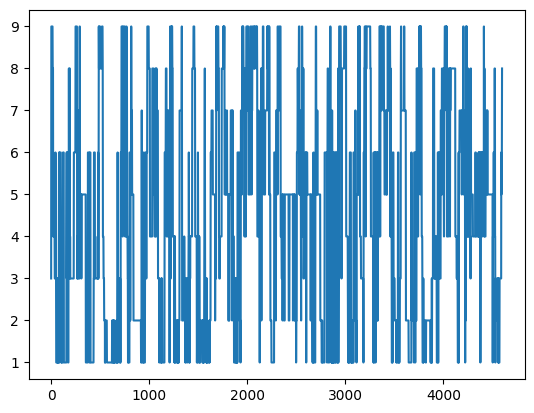

In [17]:
# plot the time series of "relabel" of df_labled using plotly
plt.plot(df_relabeled[['relabel']].tail(500).reset_index(drop=True))

# plot the time series of "relabel" of df_labled using plotly


# Prediction and Evaluation - Naive Bayes

class sklearn.naive_bayes.CategoricalNB(*, alpha=1.0, force_alpha='warn', fit_prior=True, class_prior=None, min_categories=None)[source]¶

In [18]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

nb_model = CategoricalNB()

In [73]:
def build_dataset(relabels, window_period):

    Transition_table = pd.DataFrame(relabels, columns=['T']) # create a column T as Today's label
    Transition_table['Last_median_03'] = Transition_table['T'].shift(1).rolling(window=3).median() # compute the median of the previous 3 days
    Transition_table['Last_median_10'] = Transition_table['T'].shift(1).rolling(window=10).median() # compute the median of the previous 10 days
    Transition_table['Last_median_'+str(window_period)] = Transition_table['T'].shift(1).rolling(window=window_period).median() # compute the median of the previous window period
    # Transition_table['Last_mean_'+str(window_period)] = Transition_table['T'].shift(1).rolling(window=window_period).mean().round(0) # compute the mean of the previous window period
    Transition_table['Last_max_'+str(window_period)] = Transition_table['T'].shift(1).rolling(window=window_period).max() # compute the max of the previous window period
    Transition_table['Last_min_'+str(window_period)] = Transition_table['T'].shift(1).rolling(window=window_period).min() # compute the min of the previous window period
    dataset = Transition_table.iloc[window_period+1:,:] # remove NA rows

    return dataset


def naive_bayes(dataset, nb_model, if_eval):
    
    X = dataset.drop(['T'], axis=1)
    y = dataset['T']

    Last_X = X.iloc[-1] # get today's value

    if if_eval:
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

        nb_model.fit(X_train, y_train)
        y_pred = nb_model.predict(X_test)
        # predit the last day #predict_proba return: array-like of shape (n_samples, n_classes)
        last_pred  = nb_model.predict_proba([Last_X]).round(2)[0] # make prediction
        accuracy = accuracy_score(y_test, y_pred)
    
    else:
        nb_model.fit(X, y)
        y_pred = nb_model.predict(X)
        last_pred  = nb_model.predict_proba([Last_X]).round(2)[0] # make prediction
        accuracy = None

    return last_pred, y_pred, accuracy

In [74]:
relabels = list(df_relabeled["relabel"])
dataset = build_dataset(relabels, 21)
X = dataset.drop(['T'], axis=1)
y = dataset['T']
Last_X = X.iloc[-1] # get today's value
nb_model.fit(X, y)
y_pred = nb_model.predict(X)
last_pred  = nb_model.predict_proba([Last_X]).round(2)[0] # make prediction

In [83]:
def display(df_labeled, relabel_col, monitor_period):

    df_relabeled = rename_labels(df_labeled, relabel_col)
    #mapping of labels and relabels
    mapping = dict(zip(df_relabeled["label"], df_relabeled["relabel"]))

    fig1 = px.area(
        df_relabeled[-monitor_period:],
        x=df_relabeled[-monitor_period:].index,
        y=df_relabeled[-monitor_period:]["relabel"],
        labels=dict(x="Date", y="Cycle Stage"),
        title=f"Historical Trajectory of {relabel_col}",
        height=350, width=500,
        )
    

    relabels = list(df_relabeled["relabel"])

    # Bayes model probability
    window_list = [i for i in range(20, 500) if i % 10 == 0]
    probability = np.array([0])
    accurancy = 0
    

    for window_period in window_list:

        dataset = build_dataset(relabels, window_period)
        result  = naive_bayes(dataset, nb_model, if_eval = False) # the list of probability for each culster
        pro_i = result[0]
        #acc_i = result[2]
        probability = np.add(pro_i, probability)
        #accurancy = accurancy+acc_i

    n = len(window_list)
    probability = ( probability/n).round(3)  # avarage probability for each culster
    probability = pd.DataFrame(probability)
    probability.index = probability.index+1

    #accurancy = (accurancy/n)


    fig2 = px.bar(
        probability,
        height=350, width=500,
        labels=dict(index="Cycle", value="Probability"),
        title="Transition Probability"
        )
    fig2.update(layout_showlegend=False)

    # statistics of each cluster
    summary_table = df_relabeled.groupby("relabel")[relabel_col].describe()

    # summary
    summary_table['Chance'] = probability
    summary_table['Equity_rally_odds'] = summary_table['mean'] * summary_table['Chance']
    summary_table['Equity_rally_STD'] = summary_table['std'] * summary_table['Chance']
    Mean = summary_table.Equity_rally_odds.sum().round(3)
    Std = summary_table.Equity_rally_STD.sum().round(3)

    fig1.show()
    fig2.show()
    print(summary_table.round(2)) # mean column is the chance of market rally
    print()
    print(mapping)

    print('Chance of rally in '+ relabel_col)
    print(Mean)
    print('Standard deviation')
    print(Std)

    print(window_list)
    #print(accurancy)

In [81]:
# select all column names ending with _MA21
col_list = df_labeled.columns[df_labeled.columns.str.endswith('_MA21')]
monitor_period = 600
col_list

Index(['US_equity_MA21', 'Asian_currency_MA21', 'US_bond_gov_MA21',
       'US_bond_hg_MA21', 'Copper_MA21', 'US_rates_MA21', 'Crude oil_MA21'],
      dtype='object')

# Display

In [84]:
import warnings
warnings.filterwarnings("ignore")

#for relabel_col in col_list:

    #display(df_labeled,relabel_col, monitor_period)

display(df_labeled,"US_equity_MA21", monitor_period)



         count  mean   std  min  25%  50%  75%  max  Chance  \
relabel                                                       
1        720.0  0.17  0.38  0.0  0.0  0.0  0.0  1.0    0.01   
2        521.0  0.22  0.41  0.0  0.0  0.0  0.0  1.0    0.00   
3        450.0  0.27  0.44  0.0  0.0  0.0  1.0  1.0    0.01   
4        593.0  0.40  0.49  0.0  0.0  0.0  1.0  1.0    0.01   
5        598.0  0.65  0.48  0.0  0.0  1.0  1.0  1.0    0.00   
6        454.0  0.81  0.39  0.0  1.0  1.0  1.0  1.0    0.94   
7        363.0  0.87  0.33  0.0  1.0  1.0  1.0  1.0    0.00   
8        439.0  0.89  0.31  0.0  1.0  1.0  1.0  1.0    0.02   
9        461.0  0.93  0.25  0.0  1.0  1.0  1.0  1.0    0.01   

         Equity_rally_odds  Equity_rally_STD  
relabel                                       
1                     0.00              0.00  
2                     0.00              0.00  
3                     0.00              0.00  
4                     0.00              0.00  
5                     0.